In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

from scipy import ndimage

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [43]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
models_path = data_dir / "models"
train_images_crops = data_dir/"train_crops"
mask_dir_edt = data_dir /"mask_full_size_edt"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"

In [3]:
def create_mask(json_file, data_dir, mask_dir, tile_size=1024):
    with open(data_dir/"train"/"labels"/json_file, 'r') as f:
        label = json.load(f)
    label_gdf = parse_json(label)
    if label_gdf is None or len(label_gdf) == 0:
        return
    fb_mask = sol.vector.mask.df_to_px_mask(df=label_gdf, geom_col="geometry_pixel",
                                         channels=['footprint'],
                                         shape=(tile_size,tile_size)).squeeze()
    # print(fb_mask.shape)
    PIL.Image.fromarray(fb_mask, mode='L').save(mask_dir/(json_file.replace('.json', '.png')))

#### mask creation test

In [4]:
pre_images = [x for x in mask_dir.ls() if 'pre_' in x.name]
pre_images[10]

PosixPath('/media/wwymak/Storage/xView2/mask_full_size/hurricane-harvey_00000022_pre_disaster.png')

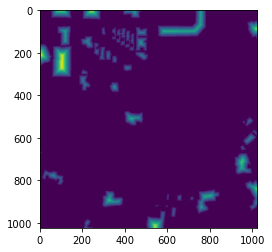

In [13]:
sample_mask = np.array(PIL.Image.open(pre_images[10]))[:,:,0] /255
inverted_sample_mask = 1 - sample_mask
transformed = ndimage.distance_transform_edt(sample_mask)
trasformed_inverted = ndimage.distance_transform_edt(inverted_sample_mask) * -1
plt.imshow(transformed / transformed.max() * 255)

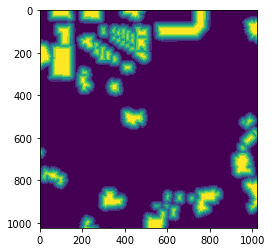

In [31]:
combined = transformed + trasformed_inverted

bins =np.arange(-20, 20, 5)
combined_binned = np.digitize(combined, bins, right=False)
plt.imshow(combined_binned / combined_binned.max() * 255)


In [32]:
np.unique(combined_binned)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [24]:
trasformed_inverted_binned.shape

(1024, 1024)

#### after runnign create_edt_mask.py

8 0 [0 1 2 3 4 5 6 7 8]


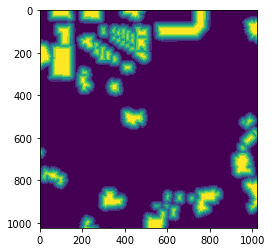

In [7]:
# run create_edt_mask.py
# sanity check:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir_edt = data_dir /"mask_full_size_edt"
sample_file = mask_dir_edt.ls()[10]

img = np.array(PIL.Image.open(sample_file))
plt.imshow(img)

print(img.max(), img.min(), np.unique(img))

#### Create crops

In [7]:
mask_dir_edt.ls()[:2]

[PosixPath('/media/wwymak/Storage/xView2/mask_full_size_edt/midwest-flooding_00000319_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/mask_full_size_edt/hurricane-florence_00000392_pre_disaster.png')]

In [13]:
from mask_extraction import create_small_tiles_masks
from tqdm import tqdm_notebook

mask_crops_edt = data_dir/"mask_crops_edt"
mask_crops_edt.mkdir(exist_ok=True)

create_tile = partial(create_small_tiles_masks, save_dir=mask_crops_edt)
mask_filepaths_edt = mask_dir_edt.ls()
# [create_tile(img_filepath, mask_filepath, im_id) for (img_filepath, mask_filepath, im_id) in zip(img_filepaths, mask_filepaths, img_ids )]
_ = Parallel(n_jobs=14)(delayed(create_tile)(mask_filepath)for mask_filepath in tqdm(mask_filepaths_edt))
# fro


100%|██████████| 2283/2283 [00:08<00:00, 266.42it/s]


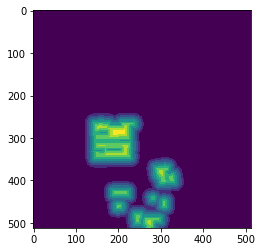

In [18]:
a = np.array(PIL.Image.open(mask_crops_edt.ls()[100]))
a.max(), a.min()
plt.imshow(a/a.max() * 255)

In [27]:
train_images_crops.ls()[10]

PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-matthew_00000245_pre_disaster._8.png')

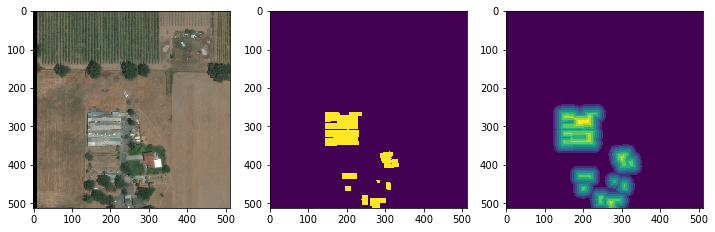

In [30]:
fname = "mask_santa-rosa-wildfire_00000136_pre_disaster_1.png"
a = np.array(PIL.Image.open(mask_crops_edt /fname))
b = np.array(PIL.Image.open(train_mask_crops/fname.replace("disaster_", "disaster._")))
c = np.array(PIL.Image.open(train_images_crops/fname.replace('mask', 'rgb').replace("disaster_", "disaster._")))

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs = ax.ravel()
axs[0].imshow(c)
axs[1].imshow(b/b.max() * 255)
axs[2].imshow(a/a.max() * 255)
# train_mask_crops

#### first attempt at multitask net fastai 

In [33]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [34]:
def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)
    
    

In [80]:

size=256
bs=16
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom


class SegLabelListEdt(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=False, convert_mode='I')

class SegItemListEdt(SegmentationItemList):
    _label_cls = SegLabelListEdt
    
segmentation_labels = (
    SegItemListCustom.from_folder(train_images_crops)
      .split_by_valid_func(is_valid_func)
       .label_from_func(lambda fname: train_mask_crops / fname.name.replace("rgb", "mask"), classes=["void", "building"])
)
edt_labels = (
    SegItemListEdt.from_folder(train_images_crops)
      .split_by_valid_func(is_valid_func)
       .label_from_func(lambda fname: mask_crops_edt / fname.name.replace("rgb", "mask").replace("disaster._", "disaster_"),
                        classes=np.arange(0, 9)
        )
)

In [44]:
accuracy_pixel=partial(foreground_acc, void_code=0)
f1_score = partial(fbeta, thresh=0.2, beta = 1)

wd =1e-2

metrics = [accuracy_pixel,dice]

multitask_project = {
    'segmentation': {
        'label_lists': segmentation_labels,
        'metric': metrics
    },
    'edt': {
        'label_lists': edt_labels,
        'metric': metrics
    }
}


#### Sanity check single models

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


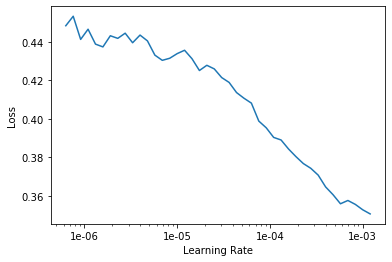

In [47]:
del learn
gc.collect()
# src = (SegItemListCustom.from_folder(train_images_crops)
#       .split_by_valid_func(is_valid_func)
#        .label_from_func(lambda fname: train_mask_crops / fname.name.replace("rgb", "mask"), classes=['void', 'building']))

data_segmentation = (segmentation_labels.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


learn = unet_learner(data_segmentation, models.resnet34, metrics=multitask_project["segmentation"]["metric"])
learn.to_fp16();
learn.lr_find()
learn.recorder.plot();



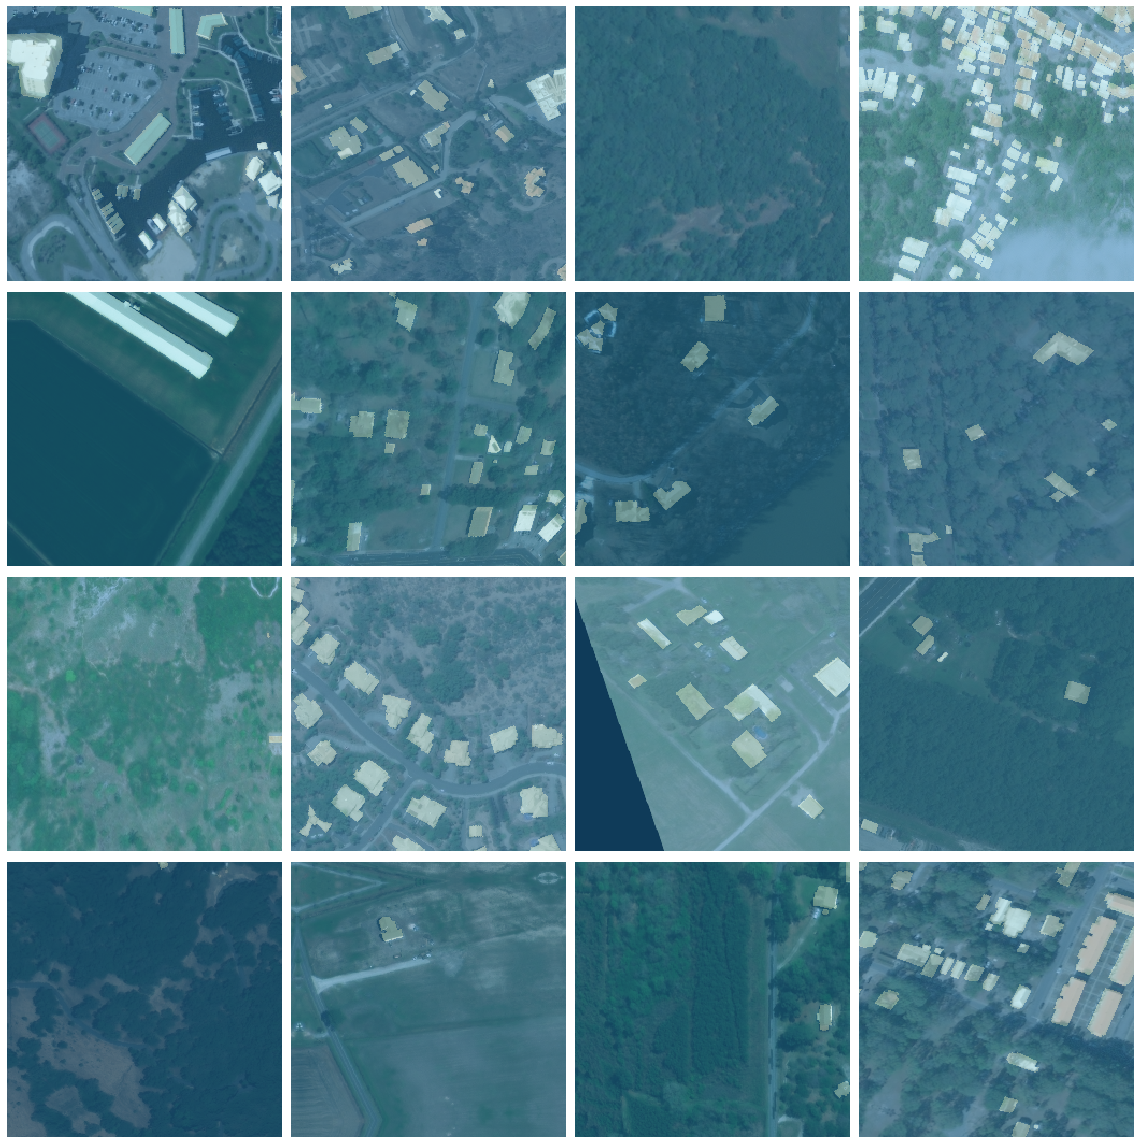

In [48]:
data_segmentation.show_batch()

In [49]:
wd=1e-2
lr=1e-4

learn.model_dir = models_path
callbacks=[
#     SaveModelCallback(learn, every='improvement', monitor='f1_score', name='xview_buildings_default_unet'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(5, slice(lr), callbacks=callbacks, wd=wd)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.150435,0.150337,0.295632,0.349539,03:23
1,0.119551,0.108128,0.740066,0.627225,03:26
2,0.105196,0.101070,0.777857,0.659591,03:22
3,0.104059,0.092952,0.697108,0.640894,03:23
4,0.097455,0.091467,0.743550,0.663860,03:25


In [ ]:
class BCEDice(nn.Module):

    def __init__(self, dice=0.5, bce=0.5):
        super(CustomLoss, self).__init__()
        self.dice = dice
        self.bce = bce

    def forward(self, input, target, **kwargs):
        logits=input[:,1,:,:].float()
        labels = target.squeeze(1).float()
                     
        bce_dice = BCEDiceLoss(dice_weight=self.dice, bce_weight=self.bce)
        
        total_loss = bce_dice(logits, labels) #+ 0.2 * lovaz_loss(logit, target)
        return total_loss


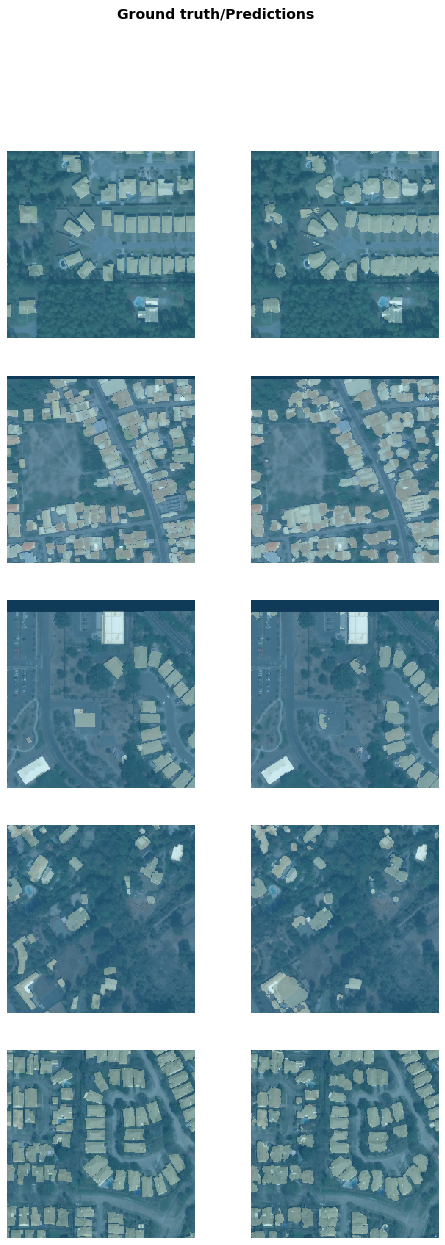

In [51]:
learn.show_results()

In [ ]:
learn.loss_func = BCEDice(dice=0.8, bce=0.2)

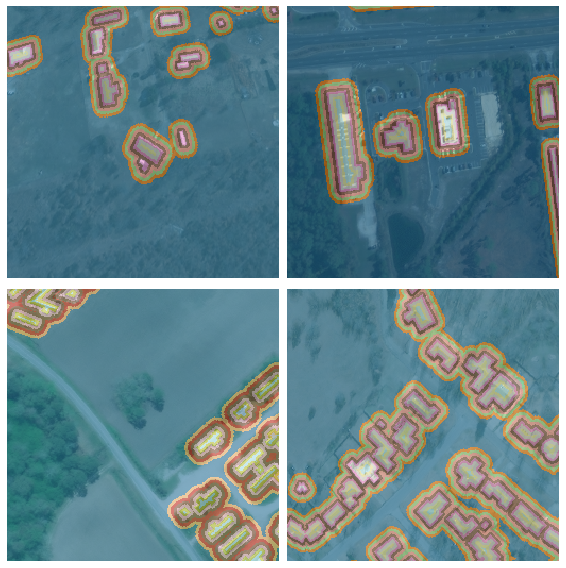

In [81]:
data_edt = (edt_labels.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))
data_edt.show_batch()


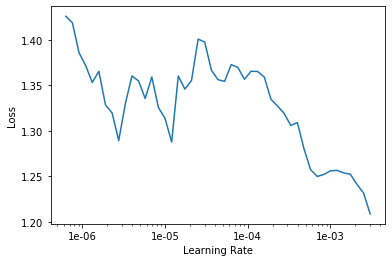

In [83]:


wd =1e-2
learn_edt = unet_learner(data_edt, models.resnet34, metrics=multitask_project["edt"]["metric"])
learn_edt.to_fp16();
learn_edt.lr_find()
learn_edt.recorder.plot();



In [84]:
lr=1e-4

learn_edt.model_dir = models_path
callbacks=[
#     SaveModelCallback(learn, every='improvement', monitor='f1_score', name='xview_buildings_default_unet'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn_edt.fit_one_cycle(5, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.686154,0.568344,0.238741,2.816051,05:21
1,0.573234,0.479006,0.348707,3.043999,05:08
2,0.494267,0.445047,0.421527,3.399707,05:19
3,0.471449,0.429656,0.450198,3.493593,05:07
4,0.483806,0.427684,0.441898,3.431431,05:03


In [42]:
class MultitaskDataset(Dataset):
    "`Dataset` for joint single and multi-label image classification."
    def __init__(self, 
                 fns,
                 labels_gender,
                 labels_race,
                 ages,
                 classes_race,
                 classes_gender):
        self.x = np.array(fns)
        
        self.classes_gender = classes_gender
        self.classes_race = classes_race

        self.class2idx_gender = {v:k for k,v in enumerate(self.classes_gender)}
        self.y_gender = np.array([self.class2idx_gender[o] for o in labels_gender], dtype=np.int64)

        self.class2idx_race = {v:k for k,v in enumerate(self.classes_race)}
        self.y_race = np.array([self.class2idx_race[o] for o in labels_race], dtype=np.int64)
        
        self.y_age = ages[:, None].astype('float32')
        
        self.c_gender = len(classes_gender)
        self.c_race = len(classes_race)
        self.c_age = 1

        self.c = self.c_gender + self.c_race + self.c_age

    
    def __len__(self): return len(self.x)
    
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray, np.ndarray]: 
        return open_image(self.x[i]), torch.tensor([self.y_gender[i], self.y_race[i], self.y_age[i]]).float()
    
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'
In [261]:
def get_dataset(df):
    return MultitaskDataset(df.img_name, 
                            labels_gender=df.gender, 
                            labels_race=df.race,
                            ages=df.age,
                            classes_race=sorted(set(df.race)),
                            classes_gender=sorted(set(df.gender))
                           )

In [85]:
dice??